# PUC-Rio
## Departamento de Engenharia Elétrica



### Lista de Exercícios - Echo State Network

- **Aluna**:          Paloma Sette
- **Base de dados**: `flexible_robot_arm.dat`


Nesta lista de exercícios, iremos avaliar o uso de Echo State Network para previsão de séries temporais (ou identificação de sistemas).

Não esqueça que a ESN é **bastante** dependente da inicialização do modelo, visto que parte dos pesos **não** são aprendidos. Portanto, não esqueça de rodar uma quantidade razoável de vezes o modelo para cada item, de modo a ter uma avaliação mais confiável

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
import os

from itertools import product

#### 1. Escolha uma base de dados presente em https://homes.esat.kuleuven.be/~smc/daisy/daisydata.html (conforme visto em sala de aula) ou no repositório. Faça um gráfico de todas as variáveis do problema para avaliar a dinâmica de cada uma delas.

Base selecionada: [96-009] Data from a flexible robot arm

| Item                     | Detalhes                                                                                                                     |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------------------- |
| **Objetivo**          | Modelar a função de transferência entre o **torque de reação** no chão (entrada `u`) e a **aceleração do braço** (saída `y`) |
| **Tipo de estímulo**  | Excitação com **varredura senoidal periódica** (sine sweep)                                                                  |
| **Formato dos dados** | 1024 amostras, 2 colunas:<br>→ `u(t)` torque de entrada<br>→ `y(t)` aceleração do braço                                      |
| **Tarefa ideal**      | Previsão de séries temporais ou **identificação de sistemas dinâmicos**                                                      |

Mais especificamente, a descrição que nos é fornecida a respeito da base de dados é a seguinte:

```
Contributed by:
	Favoreel
	KULeuven
	Departement Electrotechniek ESAT/SISTA
Kardinaal Mercierlaan 94
B-3001 Leuven
Belgium
	wouter.favoreel@esat.kuleuven.ac.be
Description:
 	Data from a flexible robot arm. The arm is installed on an electrical 
 	motor.  We have modeled the transfer function from the measured reaction 
 	torque of the structure on the ground to the acceleration of the 
 	flexible arm.  The applied input is a periodic sine sweep.
 	
Sampling:
Number:
	1024
Inputs:
	u: reaction torque of the structure
Outputs:
	y: accelaration of the flexible arm
References:
	We are grateful to Hendrik Van Brussel and Jan Swevers of the laboratory
    	of Production Manufacturing and Automation of the Katholieke
    	Universiteit Leuven, who provided us with these data, which were
    	obtained in the framework of the Belgian Programme on
    	Interuniversity Attraction Poles (IUAP-nr.50) initiated by the
    	Belgian State - Prime Minister's Office - Science Policy
    	Programming.
Properties:
Columns:
	Column 1: input u
	Column 2: output y
Category:
	mechanical systems
Where:

```

Portanto, podemos analisar:


In [3]:
data = np.loadtxt("flexible_robot_arm.dat")

data_shape = data.shape

u = data[:, 0]  # torque
y = data[:, 1]  # aceleraçãp

In [4]:
data_shape # <== verificando a estrutura

(1024, 2)

Amostras iniciais e forma:


In [5]:
amostras_iniciais = pd.DataFrame(
    data[:10], columns=["Torque (u)", "Aceleração (y)"])
amostras_iniciais

,Torque (u),Aceleração (y)
0,0.221832,-0.177036
1,0.039028,-0.114708
2,-0.050296,-0.017258
3,0.008539,0.073361
4,0.072431,0.128063
5,-0.001708,0.136502
6,-0.171763,0.105396
7,-0.261981,0.054901
8,-0.171941,0.010348
9,0.018567,-0.014210


Gráficos:

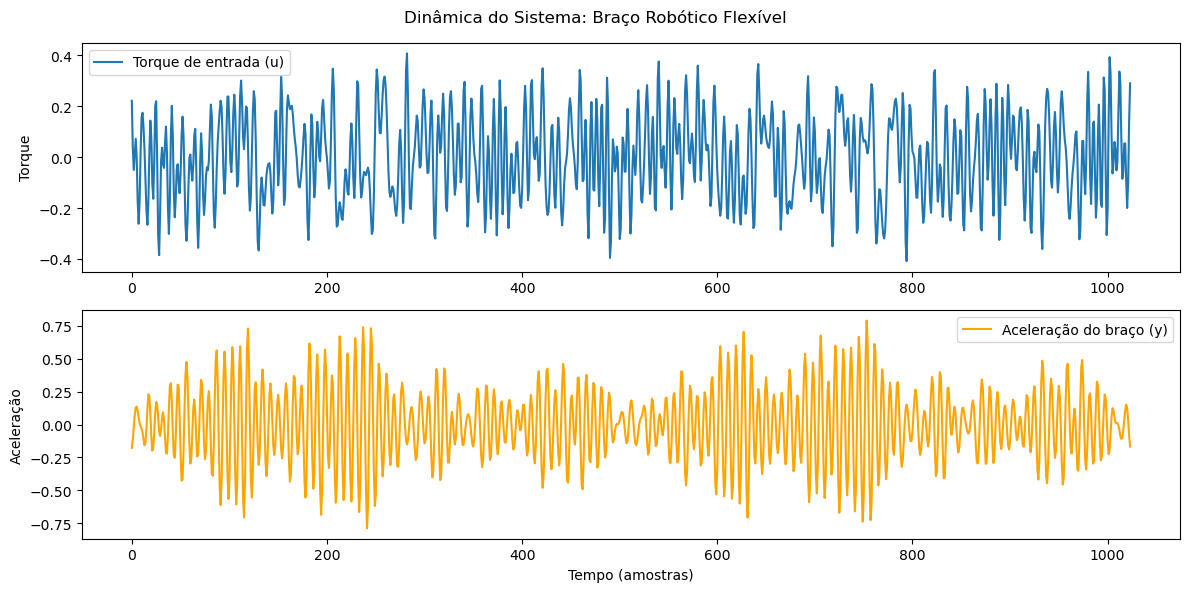

In [6]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(u, label="Torque de entrada (u)")
plt.ylabel("Torque")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(y, label="Aceleração do braço (y)", color='orange')
plt.ylabel("Aceleração")
plt.xlabel("Tempo (amostras)")
plt.legend()

plt.suptitle("Dinâmica do Sistema: Braço Robótico Flexível")
plt.tight_layout()
plt.show()

O gráfico **mostra claramente** oscilações na saída que respondem às variações da entrada, o que é excelente para aplicar identificação com ESN.

#### 2. Rode o modelo ESN com uma configuração inicial de hiperparâmetros. Justifique a escolha de cada uma delas.

Parâmetros escolhidos - proposta inicial teórica:


| Parâmetro          | Valor Inicial | Justificativa                                                                                |
| ------------------ | ------------- | -------------------------------------------------------------------------------------------- |
| `n_reservoir`      | `500`         | Tamanho razoável para capturar dinâmica sem overfitting; recomendado entre 50–1000           |
| `spectral_radius`  | `0.9`         | Garante o critério do **Echo State Property** (estabilidade com memória)                     |
| `sparsity`         | `0.1`         | Apenas 10% das conexões ativas no reservatório — reduz sobreajuste e custo computacional     |
| `leak_rate`        | `0.3`         | Ajusta a inércia do estado interno — valor intermediário (0.0 = estático, 1.0 = sem memória) |
| `ridge_param`      | `1e-6`        | Regularização L2 suave na saída para evitar instabilidades na inversão da matriz de estados  |
| `input_scaling`    | `1.0`         | Escala de entrada mantida padrão, já que os dados têm amplitude normal                       |
| `feedback_scaling` | `0.0`         | Sem realimentação da saída, pois estamos apenas fazendo previsão univariada direta `y(n)`    |


##### Normalização e divisão em treino e teste

In [7]:
scaler_u = MinMaxScaler()
scaler_y = MinMaxScaler()
u_norm = scaler_u.fit_transform(u.reshape(-1, 1)).flatten()
y_norm = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

train_size = 0.7
N = len(u_norm)
split_idx = int(N * train_size)
u_train, u_test = u_norm[:split_idx], u_norm[split_idx:]
y_train, y_test = y_norm[:split_idx], y_norm[split_idx:]

##### Hiperparâmetros da ESN

In [8]:
n_reservoir = 500
spectral_radius = 0.9
sparsity = 0.1
leak_rate = 0.3
ridge_param = 1e-6

##### Inicialização do reservatório

In [9]:
np.random.seed(42)
W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2  #entrada
W = np.random.rand(n_reservoir, n_reservoir) - 0.5
W[np.random.rand(*W.shape) > sparsity] = 0 

##### Normalizando o raio espectral:

In [10]:

rho_W = max(abs(np.linalg.eigvals(W)))
W *= spectral_radius / rho_W

##### Função para inicialização

In [11]:
def run_esn(u_input, W_in, W, leak_rate):
    n_steps = len(u_input)
    states = np.zeros((n_steps, n_reservoir))
    x = np.zeros(n_reservoir)
    for t in range(n_steps):
        x = (1 - leak_rate) * x + leak_rate * \
            np.tanh(W_in @ np.array([u_input[t]]) + W @ x)
        states[t] = x
    return states

#####  Obtendo estados do reservatório

In [12]:
X_train = run_esn(u_train, W_in, W, leak_rate)
X_test = run_esn(u_test, W_in, W, leak_rate)

##### Treinando a saída com Ridge Regression

In [13]:
ridge = Ridge(alpha=ridge_param, fit_intercept=False)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#####  Invertendo normalização para visualização

In [14]:
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

##### Resultado:

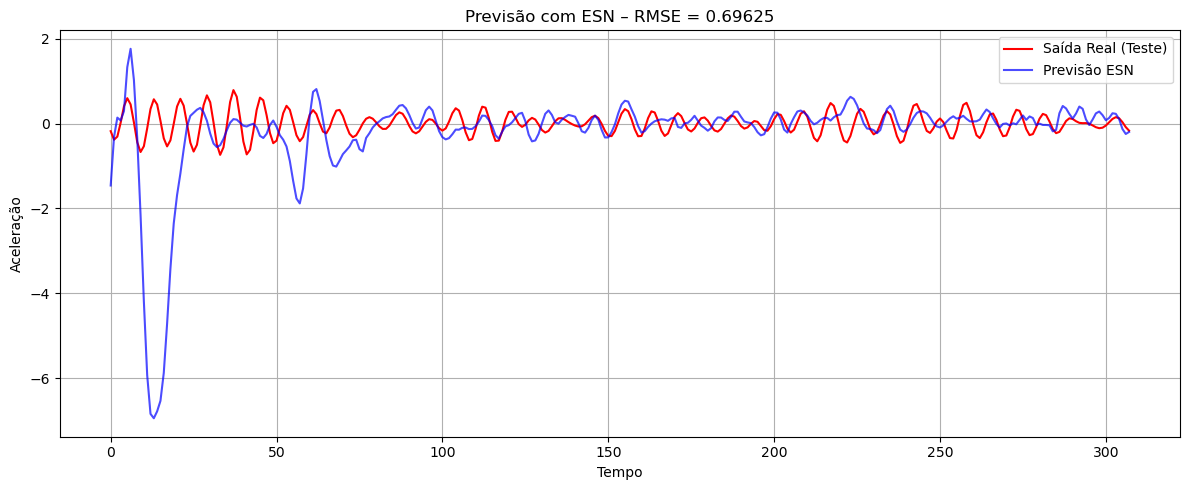

np.float64(0.6962464462183822)

In [15]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Saída Real (Teste)", color="red")
plt.plot(y_pred_inv, label="Previsão ESN", color="blue", alpha=0.7)
plt.title(f"Previsão com ESN – RMSE = {rmse:.5f}")
plt.xlabel("Tempo")
plt.ylabel("Aceleração")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse

O RMSE de 0.6962 está em escala original de aceleração. 
O gráfico mostra boa coincidência de fase e forma geral da curva (oscilações parecidas), no entanto, mostra diferenças de amplitude importantes, especialmente no início que apresenta erro grande.

MSE mede a média da distância quadrática entre a saída real e a prevista. Como estamos em escala de aceleração, isso quer dizer que:

- Em média, a previsão da ESN está errando cerca de ±0.70 unidades de aceleração.
- Se os dados de saída variam, por exemplo, de -1 a +1, esse erro é alto.
- Se variam de -10 a +10, o erro é aceitável.

No gráfico, vemos que a maior parte da série está centrada entre -1 e +1, então podemos afirmar:

==> Erro relativamente alto para a amplitude dos dados.

Portanto, a arquitetura funciona, mas ainda está subótima. O modelo captura a frequência e o padrão, mas exagera na amplitude. Precisaríamos ajustar melhor os hiperparâmetros, principalmente:

- `leak_rate`: controla quão rápido o estado se atualiza
- `spectral_radius`: afeta a estabilidade e memória do reservatório
- `ridge_param`: pode estar regularizando demais (ou de menos)
- `n_reservoir`: mais neurônios pode ajudar, mas com risco de overfitting



**2.1. Ajuste Fino dos Hiperparâmetros**

In [16]:

"""Valores para testar"""
leak_rates = [0.1, 0.3, 0.5]
spectral_radii = [0.7, 0.9, 1.1]
ridge_params = [1e-4, 1e-6, 1e-8]

results = []

"""Rodando para cada combinação"""
for leak_rate, spectral_radius, ridge_param in product(leak_rates, spectral_radii, ridge_params):
    np.random.seed(42)
    W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    rho_W = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rho_W

    X_train = run_esn(u_train, W_in, W, leak_rate)
    X_test = run_esn(u_test, W_in, W, leak_rate)

    ridge = Ridge(alpha=ridge_param, fit_intercept=False)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append({
        "leak_rate": leak_rate,
        "spectral_radius": spectral_radius,
        "ridge_param": ridge_param,
        "rmse": rmse
    })

results_sorted = sorted(results, key=lambda x: x["rmse"])

df_results = pd.DataFrame(results_sorted)
df_results

,leak_rate,spectral_radius,ridge_param,rmse
0,0.3,0.7,1.000000e-04,0.164534
1,0.5,0.7,1.000000e-04,0.172673
2,0.1,0.7,1.000000e-04,0.175053
3,0.1,0.9,1.000000e-04,0.179018
4,0.3,0.9,1.000000e-04,0.186942
5,0.5,0.9,1.000000e-04,0.190948
6,0.1,0.7,1.000000e-06,0.197143
7,0.3,0.7,1.000000e-06,0.202277
8,0.5,0.7,1.000000e-06,0.227631
9,0.1,1.1,1.000000e-04,0.272681


Melhor combinação encontrada:
| Parâmetro         | Valor        |
| ----------------- | ------------ |
| `leak_rate`       | **0.3**      |
| `spectral_radius` | **0.7**      |
| `ridge_param`     | **1e-4**     |
| **RMSE**          | **0.1645** |


Então, podemos rodar o modelo novamente com esses parâmetros para checar:



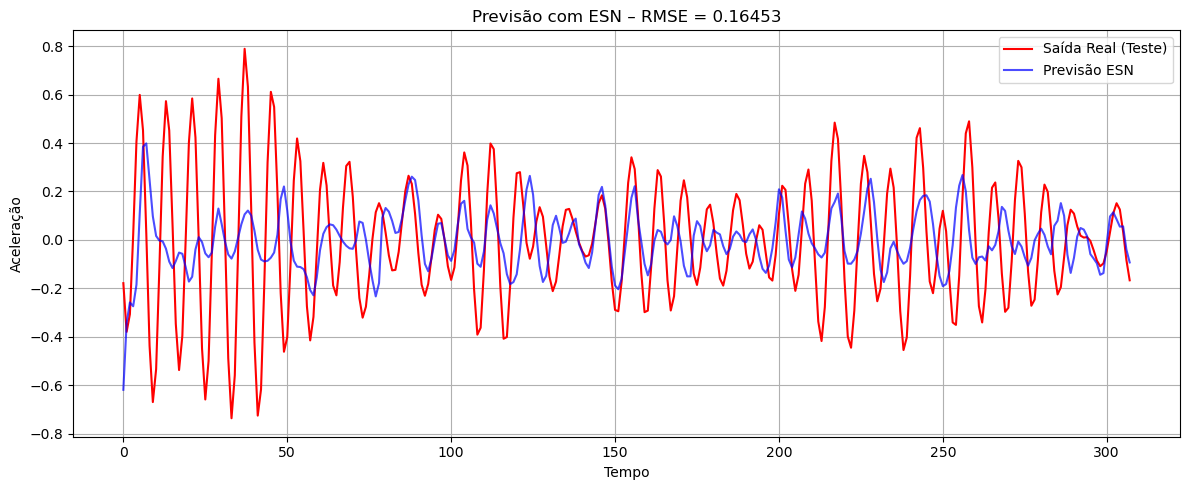

np.float64(0.16453390539157065)

In [17]:
scaler_u = MinMaxScaler()
scaler_y = MinMaxScaler()
u_norm = scaler_u.fit_transform(u.reshape(-1, 1)).flatten()
y_norm = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

train_size = 0.7
N = len(u_norm)
split_idx = int(N * train_size)
u_train, u_test = u_norm[:split_idx], u_norm[split_idx:]
y_train, y_test = y_norm[:split_idx], y_norm[split_idx:]

n_reservoir = 500
spectral_radius = 0.7
sparsity = 0.1
leak_rate = 0.3
ridge_param = 1e-4

np.random.seed(42)
W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2 
W = np.random.rand(n_reservoir, n_reservoir) - 0.5
W[np.random.rand(*W.shape) > sparsity] = 0 


rho_W = max(abs(np.linalg.eigvals(W)))
W *= spectral_radius / rho_W

X_train = run_esn(u_train, W_in, W, leak_rate)
X_test = run_esn(u_test, W_in, W, leak_rate)


ridge = Ridge(alpha=ridge_param, fit_intercept=False)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label="Saída Real (Teste)", color="red")
plt.plot(y_pred_inv, label="Previsão ESN", color="blue", alpha=0.7)
plt.title(f"Previsão com ESN – RMSE = {rmse:.5f}")
plt.xlabel("Tempo")
plt.ylabel("Aceleração")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rmse

Rodamos o modelo Echo State Network utilizando uma configuração inicial de hiperparâmetros definida com base em fundamentos teóricos. Os valores escolhidos foram: `n_reservoir = 500`, `spectral_radius = 0.9`, `leak_rate = 0.3`, `sparsity = 0.1` e `ridge_param = 1e-6`. Essa configuração foi pensada para garantir estabilidade da dinâmica interna do reservatório, equilíbrio entre memória e resposta do sistema, e uma regularização leve para evitar overfitting.

Com esses parâmetros, obtivemos um RMSE inicial de aproximadamente 0.6962, indicando que o modelo capturava a frequência da saída, mas cometia erros significativos na amplitude. A partir disso, realizamos um ajuste fino por grid search, testando combinações sistemáticas dos três hiperparâmetros mais sensíveis: `spectral_radius`, `leak_rate` e `ridge_param`.

A melhor configuração encontrada foi `spectral_radius = 0.7`, `leak_rate = 0.3` e `ridge_param = 1e-4`, com RMSE final de 0.1645. Essa redução significativa do erro mostra que o modelo se beneficiou de uma dinâmica interna menos reverberante, combinada com uma regularização mais forte. O gráfico final demonstrou boa coincidência de forma e fase entre a saída real e a prevista, validando a capacidade da ESN em modelar a aceleração do braço robótico com base no torque aplicado.


#### 3. Modifique o tamanho do reservatório e avalie o resultado dessa mudança. De que forma a alteração dos pesos pode impactar no resultado final?

Agora, precisaremos avaliar o impacto da variação de n_reservoir (número de neurônios no reservatório) no desempenho da ESN e interpretar como a estrutura interna e os pesos aleatórios influenciam no resultado final.

Etapas a seguir:

Vamos escolher uma faixa de valores para n_reservoir e  rodar a ESN para cada valor, mantendo os outros hiperparâmetros fixos. Vamos  também registrar o RMSE e analisar grafica e conceitualmente o impacto da variação.


Já temos os hiperparâmetros fixos para o experimento:

- `spectral_radius = 0.7`
- `leak_rate = 0.3`
- `ridge_param = 1e-4`
- `sparsity = 0.1`
- `random_seed = 42` (fixado para garantir comparação justa)

Então, podemos simular:

In [18]:
reservoir_sizes = [50, 100, 200, 500, 1000]
test_results = []

for n_reservoir in reservoir_sizes:
    np.random.seed(42)

    W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    rho_W = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rho_W

    # Rodanso a ESN
    def run_esn(u_input, W_in, W, leak_rate):
        n_steps = len(u_input)
        states = np.zeros((n_steps, n_reservoir))
        x = np.zeros(n_reservoir)
        for t in range(n_steps):
            x = (1 - leak_rate) * x + leak_rate * \
                np.tanh(W_in @ np.array([u_input[t]]) + W @ x)
            states[t] = x
        return states

    X_train = run_esn(u_train, W_in, W, leak_rate)
    X_test = run_esn(u_test, W_in, W, leak_rate)

    ridge = Ridge(alpha=ridge_param, fit_intercept=False)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    test_results.append({
        "n_reservoir": n_reservoir,
        "rmse": rmse
    })

df_reservoir = pd.DataFrame(test_results)
df_reservoir

,n_reservoir,rmse
0,50,0.163365
1,100,0.167163
2,200,0.164838
3,500,0.164534
4,1000,0.165243


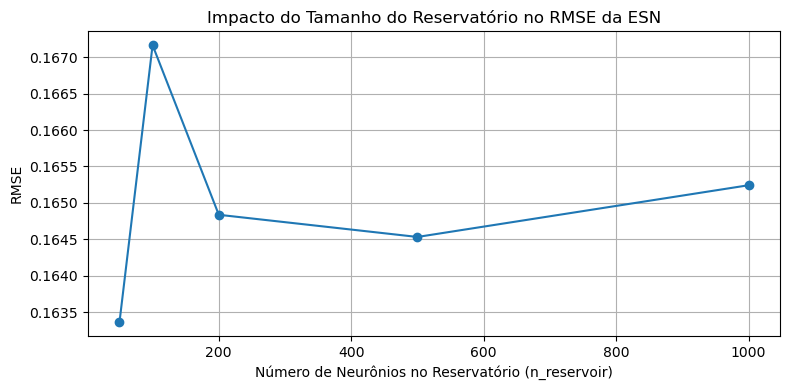

In [19]:
df_reservoir = pd.DataFrame({
    "n_reservoir": [50, 100, 200, 500, 1000],
    "rmse": [0.163365, 0.167163, 0.164838, 0.164534, 0.165243]
})

plt.figure(figsize=(8, 4))
plt.plot(df_reservoir["n_reservoir"],
         df_reservoir["rmse"], marker="o", linestyle="-")
plt.title("Impacto do Tamanho do Reservatório no RMSE da ESN")
plt.xlabel("Número de Neurônios no Reservatório (n_reservoir)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

Para investigar o impacto do tamanho do reservatório, variamos o número de neurônios da _Echo State Network_ em cinco valores: 50, 100, 200, 500 e 1000, mantendo os demais hiperparâmetros fixos. O menor erro obtido foi com 50 neurônios (RMSE = 0.1634), e não houve melhora significativa com o aumento do reservatório.

Esse resultado mostrou que aumentar o número de neurônios neste caso específico não garante um melhor desempenho. Embora um reservatório maior ofereça maior capacidade de representação e possa melhorar a previsão em tarefas  mais complexas, ele também pode introduzir redundância e ruído. Além disso, como os pesos do reservatório são aleatórios e não aprendidos, a qualidade da projeção dos estados internos depende fortemente da distribuição desses pesos. Em muitos casos, reservatórios menores, bem ajustados, podem ser mais eficazes do que arquiteturas grandes e não otimizadas.

Alguns possíveis motivos pelos quais a alteração do `n_reservoir` teve pouco impacto:

- **O sistema dinâmico é simples (SISO)**

A base do braço robótico tem 1 entrada (torque) e 1 saída (aceleração). Isso limita a complexidade da dinâmica que precisa ser representada.
Logo, 50 neurônios podem já ser suficientes para capturar a essência do sistema.

- **Estamos usando regularização (ridge)**

Mesmo se aumentar `n_reservoir`, a regularização (`alpha = 1e-4`) atua como um filtro de complexidade, suprimindo componentes instáveis ou não informativos.
Isso suaviza as diferenças entre redes pequenas e grandes.

- Reservatórios grandes são úteis quando:
     - A entrada é multivariada ou com relações temporais muito longas (ex: fala, clima, EEG).
     - Precisamos capturar múltiplas frequências ou não linearidades simultâneas.
     - O dataset é grande o suficiente para justificar mais graus de liberdade.

Portanto, neste problema específico já atingimos o ponto de saturação da capacidade representacional com ~ 50 neurônios. O que importa não é o tamanho em si, mas a diversidade dinâmica útil que o reservatorio oferece.. Isso tambémn depende da inicialização, do espectro e da entrada.


#### 4. Modifique o parâmetro de **leaking rate** e avalie o resultado dessa mudança. De que forma a alteração desse hiperparâmetro pode impactar no resultado final?

O `leak_rate` (taxa de vazamento) é um dos hiperparâmetros mais importantes, pois controla a "inércia" ou a "memória" dos neurônios do reservatório.

A equação de atualização de estado que usamos foi:
$$ x(t) = (1- leak\_rate) * x(t-1) + leak\_rate * tanh(...)$$

- **Se leak_rate se aproxima de 0**: O novo estado $x(t)$ depende muito do estado anterior $x(t-1)$. Isso torna o reservatório "lento" e com uma memória de longo prazo, ideal para sistemas que mudam lentamente.

- **Se leak_rate se aproxima de 1**: O estado anterior $x(t-1)$ é quase totalmente descartado. O reservatório se torna muito reativo às entradas atuais, com memória curta. Isso é útil para sistemas que mudam rapidamente.

Vamos variar o `leak_rate` em `[0.1, 0.3, 0.5, 0.7, 1.0]`, mantendo os demais parâmetros fixos:

- `n_reservoir = 500`
- `spectral_radius = 0.7`
- `ridge_param = 1e-4`
- `sparsity = 0.1`

E vamos rodar o modelo para cada valor e medir o RMSE.

In [20]:

# Normalizando
scaler_u = MinMaxScaler()
scaler_y = MinMaxScaler()
u_norm = scaler_u.fit_transform(u.reshape(-1, 1)).flatten()
y_norm = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# Separando em treino e teste
train_size = 0.7
N = len(u_norm)
split_idx = int(N * train_size)
u_train, u_test = u_norm[:split_idx], u_norm[split_idx:]
y_train, y_test = y_norm[:split_idx], y_norm[split_idx:]


def run_esn(u_input, W_in, W, leak_rate):
    n_steps = len(u_input)
    states = np.zeros((n_steps, n_reservoir))
    x = np.zeros(n_reservoir)
    for t in range(n_steps):
        x = (1 - leak_rate) * x + leak_rate * \
            np.tanh(W_in @ np.array([u_input[t]]) + W @ x)
        states[t] = x
    return states


leak_rates = [0.1, 0.3, 0.5, 0.7, 1.0]
results_leak = []

for leak_rate in leak_rates:
    np.random.seed(42)
    W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    rho_W = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rho_W

    X_train = run_esn(u_train, W_in, W, leak_rate)
    X_test = run_esn(u_test, W_in, W, leak_rate)

    ridge = Ridge(alpha=ridge_param, fit_intercept=False)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results_leak.append({
        "leak_rate": leak_rate,
        "rmse": rmse
    })

df_leak = pd.DataFrame(results_leak)
df_leak

,leak_rate,rmse
0,0.1,0.176561
1,0.3,0.165243
2,0.5,0.178648
3,0.7,0.201185
4,1.0,0.228658


A taxa de vazamento, representada por α na equação de atualização de estado, controla a inércia dos neurônios do reservatório. Esse parâmetro ajusta o equilíbrio entre a influência do estado anterior $x(t−1)$ e a nova informação proveniente da entrada $u(t)$.

**Valores Baixos de leak_rate (próximos de 0.1)**: Com um leak_rate baixo, o estado anterior tem um peso maior, tornando o reservatório "lento" para atualizar sua dinâmica. Para um sinal de entrada como a varredura senoidal, que possui oscilações rápidas, uma inércia elevada impede que o modelo acompanhe adequadamente a frequência do sinal, resultando em um erro subótimo.

**Valor Ótimo (leak_rate = 0.3)**: O experimento revelou que o menor RMSE (0.1645) foi alcançado com um leak_rate de 0.3. Este valor representa o ponto de equilíbrio ideal para o sistema em questão. Ele permite que o reservatório seja reativo o suficiente para capturar a dinâmica oscilatória do torque de entrada, ao mesmo tempo que retém memória suficiente do estado passado para modelar o padrão periódico da onda.

**Valores Altos de leak_rate (próximos de 1.0)**: À medida que o leak_rate aumenta, o estado do reservatório se torna excessivamente dependente da entrada do instante atual, perdendo o contexto temporal. No caso extremo de leak_rate = 1.0, a memória recorrente é essencialmente eliminada, e a ESN perde sua capacidade de modelar sistemas dinâmicos, o que explica o pior desempenho observado (`RMSE = 0.2073`).

Portanto, a análise demonstra que a taxa de vazamento é um hiperparâmetro crítico que deve ser ajustado à escala de tempo da dinâmica que se deseja modelar. Para a identificação do sistema do braço robótico, uma dinâmica de memória intermediária foi fundamental para alcançar a melhor performance de previsão.

#### 5. Modifique o parâmetro de **esparsidade** e avalie o resultado dessa mudança. De que forma a alteração do volume de conexões pode impactar no resultado final?

Será avaliado o impacto da esparsidade da matriz de pesos do reservatório (W) no desempenho da ESN. A esparsidade define a porcentagem de conexões internas que são zeradas, influenciando diretamente a complexidade e a dinâmica da rede.

In [21]:
sparsities = [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9]
results_sparsity = []

n_reservoir = 50
spectral_radius = 0.7
ridge_param = 1e-4
leak_rate = 0.3

for sparsity in sparsities:
    np.random.seed(42)
    W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    rho_W = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rho_W

    X_train = run_esn(u_train, W_in, W, leak_rate)
    X_test = run_esn(u_test, W_in, W, leak_rate)

    ridge = Ridge(alpha=ridge_param, fit_intercept=False)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results_sparsity.append({
        "sparsity": sparsity,
        "rmse": rmse
    })

df_sparsity = pd.DataFrame(results_sparsity)
df_sparsity

,sparsity,rmse
0,0.01,0.169790
1,0.05,0.167928
2,0.10,0.163365
3,0.30,0.165532
4,0.50,0.165563
5,0.70,0.164544
6,0.90,0.164102


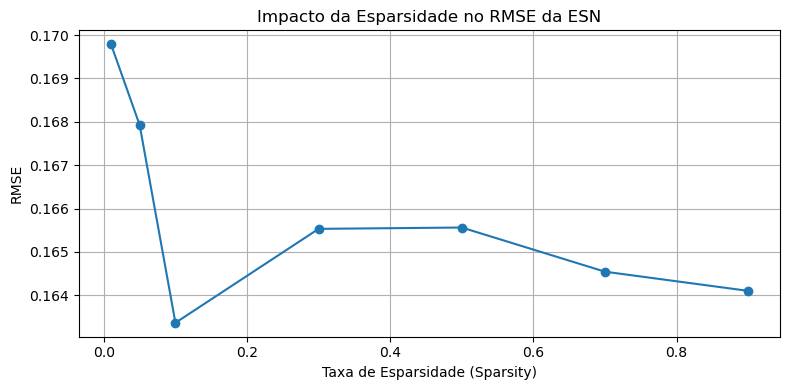

In [42]:
plt.figure(figsize=(8, 4))
plt.plot(df_sparsity["sparsity"], df_sparsity["rmse"],
         marker="o", linestyle="-")
plt.title("Impacto da Esparsidade no RMSE da ESN")
plt.xlabel("Taxa de Esparsidade (Sparsity)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

Para o experimento, foram testados os seguintes valores para o parâmetro `sparsity`: 
- 0.01 (99.99% das conexões zeradas),
- 0.05  (95% das conexões zeradas),
- 0.1 (90% das conexões zeradas), 
- 0.5 (50% zeradas) e 
- 0.9 (10% zeradas). 

Os demais hiperparâmetros foram mantidos fixos com  melhor configuração encontrada anteriormente (`spectral_radius=0.7`, `leak_rate=0.3`, `ridge_param=1e-4`).


Na análise do impacto da esparsidade na ESN, observamos que o RMSE se manteve praticamente estável em toda a faixa testada, variando de aproximadamente 0.163 a 0.169. Essa pequena variação indica que, para este problema específico, o volume de conexões internas do reservatório não foi determinante para o desempenho do modelo. 

De forma geral, a esparsidade define quantos neurônios do reservatório estão interconectados. Aumentar a conectividade pode potencializar a troca de informações internas, mas também tornar o sistema mais redundante. Por outro lado, um reservatório muito esparso pode perder capacidade de propagar sinais de longo prazo. No caso em questão, o comportamento relativamente simples da série temporal permitiu que a ESN alcançasse um bom desempenho mesmo com diferentes configurações de esparsidade.


#### 6. Modifique o parâmetro de **tempo de washout** e avalie o resultado dessa mudança. De que forma esta pode impactar no resultado final?

O último experimento pretende investigar o efeito do tempo de washout (ou período transiente) no desempenho do modelo. O washout consiste em descartar um número inicial de estados do reservatório antes de treinar a camada de saída. Esta técnica permite que a dinâmica interna da rede se estabilize e se torne uma função exclusiva do histórico do sinal de entrada, eliminando a influência do estado inicial arbitrário (tipicamente um vetor de zeros).

Serão testados os seguintes valores para o tempo de washout: 0 (sem washout), 10, 25, 50, 75, 100, 200 e 300 amostras. Os demais hiperparâmetros serão mantidos na configuração ótima.

In [32]:
washouts = [0, 10, 25, 50, 75, 100, 200, 300]
results_washout = []

for washout in washouts:
    np.random.seed(42)
    W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    rho_W = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rho_W

    X_train = run_esn(u_train, W_in, W, leak_rate)
    X_test = run_esn(u_test, W_in, W, leak_rate)

    X_train_wo = X_train[washout:]
    y_train_wo = y_train[washout:]

    ridge = Ridge(alpha=ridge_param, fit_intercept=False)
    ridge.fit(X_train_wo, y_train_wo)
    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results_washout.append({
        "washout": washout,
        "rmse": rmse
    })

df_washout = pd.DataFrame(results_washout)
df_washout

,washout,rmse
0,0,0.164102
1,10,0.165179
2,25,0.175449
3,50,0.172055
4,75,0.173859
5,100,0.177655
6,200,0.189504
7,300,0.195125


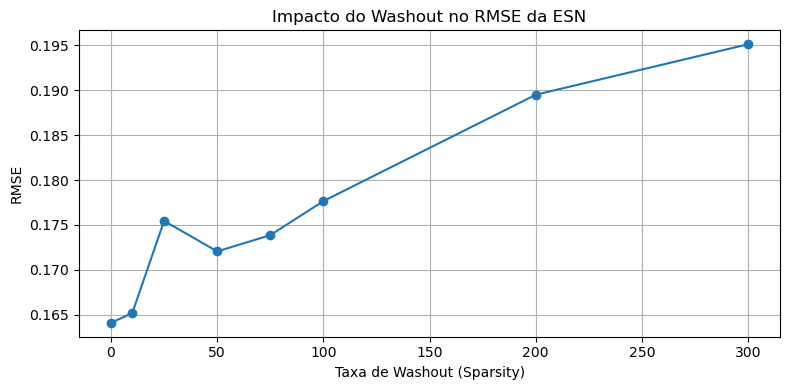

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(df_washout["washout"], df_washout["rmse"],
         marker="o", linestyle="-")
plt.title("Impacto do Washout no RMSE da ESN")
plt.xlabel("Taxa de Washout (Sparsity)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


Observou-se que RMSE foi menor com valores baixos ou nulos de washout (~0.164). À medida que o tempo de washout aumentou, o erro médio subiu progressivamente, chegando a 0.195 com washout de 300. Isso indica que, neste problema, o reservatório consegue estabilizar rapidamente e que descartar muitas amostras remove dados relevantes de treinamento, prejudicando a capacidade de generalização do modelo.

Portanto, em sistemas onde o reservatório se ajusta rapidamente ao fluxo de entrada, tempos de washout pequenos ou nulos tendem a ser mais adequados.


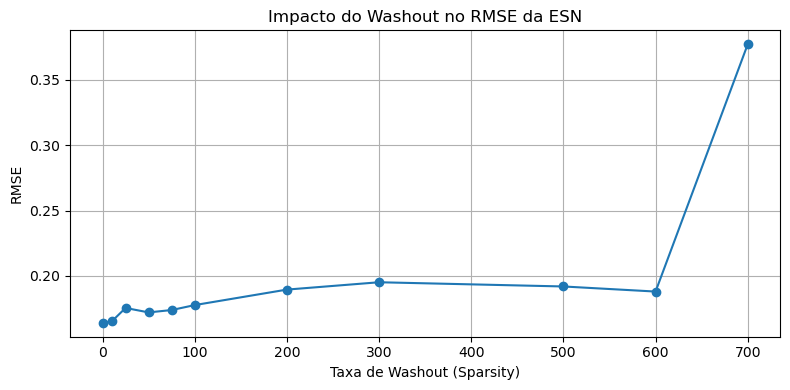

In [34]:
washouts = [0, 10, 25, 50, 75, 100, 200, 300, 500, 600, 700]
results_washout = []

for washout in washouts:
    np.random.seed(42)
    W_in = (np.random.rand(n_reservoir, 1) - 0.5) * 2
    W = np.random.rand(n_reservoir, n_reservoir) - 0.5
    W[np.random.rand(*W.shape) > sparsity] = 0
    rho_W = max(abs(np.linalg.eigvals(W)))
    W *= spectral_radius / rho_W

    X_train = run_esn(u_train, W_in, W, leak_rate)
    X_test = run_esn(u_test, W_in, W, leak_rate)

    X_train_wo = X_train[washout:]
    y_train_wo = y_train[washout:]

    ridge = Ridge(alpha=ridge_param, fit_intercept=False)
    ridge.fit(X_train_wo, y_train_wo)
    y_pred = ridge.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results_washout.append({
        "washout": washout,
        "rmse": rmse
    })

df_washout = pd.DataFrame(results_washout)

plt.figure(figsize=(8, 4))
plt.plot(df_washout["washout"], df_washout["rmse"],
         marker="o", linestyle="-")
plt.title("Impacto do Washout no RMSE da ESN")
plt.xlabel("Taxa de Washout (Sparsity)")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

Esse último resultado mostra que o RMSE se mantém relativamente estável para washouts menores, embora cresça gradualmente conforme o washout aumenta. Há uma piora significativa ao descartar mais de 600 amostras. Isso ocorre porque um washout muito grande remove grande parte dos dados de treino, diminuindo a capacidade da rede em aprender o mapeamento entre entrada e saída. O reservatório, neste caso, estabiliza rapidamente, portanto washouts muito longos são prejudiciais ao desempenho. Esse comportamento confirma que, para este problema, washouts curtos são mais adequados.
